In [1]:
#imports
#Imports
import numpy as np 
from numpy import pi
import matplotlib.pyplot as plt
import sciann as sn 
from sciann_datagenerator import *

---------------------- SCIANN 0.6.7.3 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.9.2 
Python Version: 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:14) 
[Clang 12.0.1 ] 

Outdated SciANN installation is found (V-0.6.7.3). Get the latest version (V-0.6.7.6):  
      > pip [--user] install --upgrade sciann  


Queremos una PINN que resuelva la ecuacion para un modelo de opinion tipo deffuant con heterogeneidad de los agentes. El modelo original es:

El dominio $K = [-1,1]\times [0,1]\times [0,1]$,  $\hat{\omega} in K$, $\hat{\omega} = (\omega, p, q)$

La ecuación, como está en el paper es
$$\frac{d}{d t} \int_K \phi (\hat{\omega}) d f_t(\omega) = \int_K \left( (m(t) - \omega) \langle p \rangle q  \right) \partial_\omega \phi(\hat{\omega}) d f_t(\omega)$$


donde $m(t) = \int_k \frac{\omega p}{\langle p \rangle}d f_t(\omega)$

Primero, hacemos un caso más sencillo donde $p=q=1$ siempre. La ecuación queda 

$$\frac{d}{d t} \int_K \phi (\omega) d f_t(\omega) = \int_K  (m(t) - \omega)  \partial_\omega \phi(\omega) d f_t(\omega)$$

y ahora $m(t) = m(0)$ para todo $t$.

La PDE queda

$$u_t (x) = \partial_x((m - x) u)$$
con condición de borde $u(t,-1) = u(t,1) = 0$ para todo tiempo $t$.

In [2]:
#Intervalo de tiempo
T= float(2)

dg = DataGeneratorXY([-1., 1.],[0., T], ["domain",'bc-bot','bc-left', 'bc-right'], 4000) #, "bc-right"]
input_data, target_data = dg.get_data()

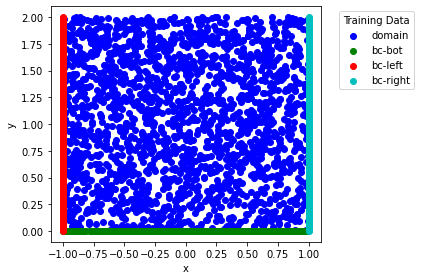

In [3]:
dg.plot_data()

In [10]:
#defino mis funcion y mis variables

#function variable
x = sn.Variable('x')

#initial condition. I treat it as a variable for the NN u.
t = sn.Variable('t')

u = sn.Functional('u', [x,t], hidden_layers = 4*[30], activation = 'tanh', res_net=True) #esta es la red neuronal cruda sin entrenar,


In [11]:
print(type(t.get_class()))

<class 'type'>


In [16]:
#aca calculo el m el centro de masa de u

def m(u, t_variable): #, values): #values should be a numpy array with the x values where I want to calculate the integral
    
    #first I calculate the mean of u with a riemmann sum
    
    #preparing the numpy arrays for calculation
    x, delta_x = np.linspace(-1,1,101, retstep=True)
    x_aux = sn.Variable('x_aux', tensor = np.linspace(-1,1,101, retstep=True))
    u_values = u.eval(x, t_variable)
    #calculating the integral
    mean = x*u_values*delta_x
    integral = mean.sum()
    
    return integral

# Hice la prueba en algunos vectores y calculo bien la media. 
# La diferencia entonces se debe a que la u no aproxima bien el dato inicial.
taux = 0
m(u,t)


TypeError: __init__() got an unexpected keyword argument 'tensor'

In [14]:
#ahora defino la loss function para u

#m = 0

#Pido que satisfaga la ecuacion
aux=sn.sub(x,m(u,t))
#aux = sn.mul(aux,-1)
L = sn.abs(sn.diff(u, t, order = 1) - sn.diff(sn.mul(u, aux), x, order=1)  )

#Dato inicial u(0) = e - x^2

#tomo una gaussiana como dato inicial. tiene media cero, que hardcodeo en la ecuacion
C1 = (t==0) *( sn.sub(u,sn.exp(- sn.pow(x,2)) - np.e**(-1)))

C2 = (x==-1) * sn.abs(u)
C3 = (x==1) * sn.abs(u)

#IC = (t==0.) * (sn.abs( sn.sub(u, np.e^(-x^2)) ))

ValueError: setting an array element with a sequence.

-7.589415207398531e-19
8.215650382226158e-17


Text(0.5, 1.0, 'Dato Inicial')

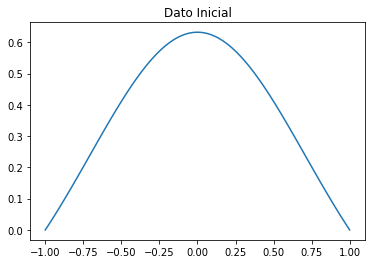

In [83]:
#ploteo el dato inicial

X= np.linspace(-1,1,100)
Y = [np.exp(-x**2) - np.e**(-1) for x in X ]


plt.plot(X,Y)
plt.title('Dato Inicial')

In [15]:
modelo = sn.SciModel([x,t], [L,C1, C2, C3], optimizer = 'adam') # C2, C3], optimizer = 'adam') #, C2, C3], optimizer = 'adam')


In [77]:
history = modelo.train(x_true = input_data, 
             y_true = target_data, 
             epochs = 120,
             learning_rate = 0.001,
             adaptive_weights={'method': 'NTK', 'freq':10, 'use_score':True})


Total samples: 5000 
Batch size: 64 
Total batches: 79 


+ NTK evaluation time [s]: 2.2120237350463867 

+ adaptive_weights at epoch 1: [0.05446650647736545, 1.9283037919918664, 1.522671211993926, 0.4945584798510871]
Epoch 1/120
79/79 [==============================] - 2s 22ms/step - batch: 39.0000 - size: 63.2911 - loss: 5.3750e-04 - abs_loss: 0.0041 - mul_3_loss: 5.3240e-05 - mul_4_loss: 1.0675e-04 - mul_5_loss: 9.4784e-05 - lr: 0.0010 - time: 3.9937 - loss_weight_0: 0.0545 - loss_weight_1: 1.9283 - loss_weight_2: 1.5227 - loss_weight_3: 0.4946 - loss_gradient_0: 1005.5986 - loss_gradient_1: 50.3903 - loss_gradient_2: 80.0224 - loss_gradient_3: 151.1628
Epoch 2/120
79/79 [==============================] - 2s 21ms/step - batch: 39.0000 - size: 63.2911 - loss: 0.0010 - abs_loss: 0.0052 - mul_3_loss: 8.0703e-05 - mul_4_loss: 2.0162e-04 - mul_5_loss: 5.4523e-04 - lr: 0.0010 - time: 1.7039 - loss_weight_0: 0.0545 - loss_weight_1: 1.9283 - loss_weight_2: 1.5227 - loss_weight_3: 0.4946 - 

In [61]:
#valores = np.arange(0,4,0.001)

valores = np.meshgrid(np.linspace(-1,1,100),np.linspace(0,T,200))
valores_y = u.eval(valores)

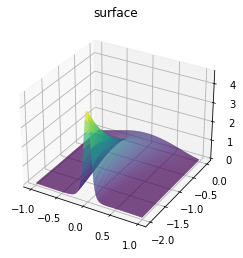

In [62]:
ax = plt.axes(projection='3d')
ax.plot_surface(valores[0], -1*valores[1], valores_y, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');


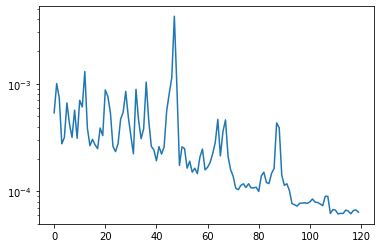

In [78]:
plt.semilogy(history.history['loss'])

Siguient paso. agregar el laplaciano $+\epsilon \Delta u$

va a haber que calcular $m(t) = \int_\Omega u(x,t) dx$

In [48]:
# Pruebas
#xt=np.meshgrid([1],[0])
#u.eval(np.meshgrid([0],[0]))
#u.eval(modelo,xt)
aux, delta_aux = np.linspace(0,1,11, retstep = True)
print(aux)
print(aux*aux*3)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.   0.03 0.12 0.27 0.48 0.75 1.08 1.47 1.92 2.43 3.  ]


In [102]:
#xt=np.meshgrid(np.linspace,[0])
#u.eval(np.meshgrid([0],[0]))
#u.eval(xt)
aux = np.arange(0,10)
print(type(aux))
modelo.predict(t,aux)

<class 'numpy.ndarray'>


ValueError: Please provide consistent number of inputs as the model is defined: Expected 2 - provided 1